<a href="https://colab.research.google.com/github/ved8696/Master-Thesis/blob/main/Thesis_Code_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Sense Disambiguation Using Neural Network Code

**Vedant Shah**

**University of Osnabrueck**

**Masters Thesis Code**

## Content

### Part 1: Setting the Path and Loading Packages
### Part 2: Preprocessing of the Raw Data
### Part 3: Models
### Part 4: Evaluation and Plots

## Part 1
### Setting the Path and Loading Packages

In [ ]:
%matplotlib inline

#### Set the path

1) Clone the following github link 

2) Set the path to run this file

In [ ]:
cd /content/drive/My Drive/Word Sense Disambiguation BILSTM/Word-Sense-Disambiguation-using-Bidirectional-LSTM/

/content/drive/My Drive/Word Sense Disambiguation BILSTM/Word-Sense-Disambiguation-using-Bidirectional-LSTM


#### Install and Load all Packages

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=16373e7fa97d89a88b426d3421172c371acaa5f42179887fdb05f06ddc463688
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


In [ ]:
import keras
from keras_self_attention import SeqSelfAttention

#### Load the data.py and glove.py file

1) data.py: The file has functions for preprocessing steps to use the data


2) glove.py: load the pre-trained Glove word embedding vector for our own dataset

In [ ]:
from data import *
from glove import *
import tensorflow as tf
from tensorflow.python import keras
#import tensorflow.nn.rnn_cell as rnn_cell
from tensorflow.keras.layers import RNN
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
from keras.layers import Layer
import keras.backend as K
 
from random import random
from numpy import array
from numpy import cumsum
from matplotlib import pyplot
from pandas import DataFrame
 
import keras
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalAveragePooling1D, TimeDistributed, GlobalMaxPooling1D, BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model
from tensorflow.keras.models import Sequential
import keras.layers.normalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
import keras.backend as K
from keras.utils.vis_utils import plot_model
from sklearn.manifold import TSNE 
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
output_notebook()
import pandas as pd
import seaborn as sns
import time
import numpy
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial import cKDTree
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

## Part 2
### Preprocessing of Data


In [ ]:
# Load Dataset
train_data_ = load_train_data(23)

EMBEDDING_DIM = 100
# build vocab utils
word_to_id = build_vocab(train_data_)
target_word_to_id, target_sense_to_id, n_words, n_senses_from_target_id = build_sense_ids(train_data_)
#build context vocab of the target sense
train_target_sense_to_context = build_context(train_data_, word_to_id)
#build context embeddings of the target sense
embedding_matrix = fill_with_gloves(word_to_id, 100)
target_sense_to_context_embedding = build_embedding(train_target_sense_to_context, embedding_matrix, len(word_to_id), EMBEDDING_DIM)



Function Description: 

convert_to_numeric_me: takes the data and creates 5 data points

1) Forward Data: Data on the the right hand side of the target word

2) Backward Data: Data from the left hand side of the target word

3) Target Sense

4) Target Word

5) Embedding of the context based on the target sense

In [ ]:
def convert_to_numeric_me(data, word_to_id, target_word_to_id, target_sense_to_id, n_senses_from_word_id, target_sense_to_context_embedding, is_training=True):
    
    n_senses_sorted_by_target_id = [n_senses_from_word_id[target_id] for target_id in range(len(n_senses_from_word_id))]
    starts = (np.cumsum(np.append([0], n_senses_sorted_by_target_id)))[:-1]
    tot_n_senses = sum(n_senses_from_word_id.values())

    all_data = []
    #target_tag_id = word_to_id['<target>']
    #print(target_tag_id)
    for instance in data:
        words = split_context(instance['context'])            
        target_word = instance['target_word'] 
        
        ctx_ints = [word_to_id[word] for word in words if word in word_to_id]
        stop_idx = words.index('<target>')
        #print(stop_idx)
        #print(ctx_ints)
        
        _instance = []
        #stop_idx = ctx_ints.index(target_tag_id)
        xf = np.array(ctx_ints[:stop_idx])
        xb = np.array(ctx_ints[stop_idx+1:])[::-1]               
       # print("xf", len(xf))
       # print("xb", len(xb))
        
        instance_id = instance['target_sense']          
        target_id = target_word_to_id[target_word]
        
        _instance.append(xf)
        _instance.append(xb)
        _instance.append(instance_id)
        _instance.append(target_word)
      #  print(len(_instance))
        if is_training:                   
            target_sense = instance['target_sense']   
            if target_sense in target_sense_to_context_embedding:
                sense_embedding = target_sense_to_context_embedding[target_sense]
                senses = target_sense_to_id[target_id]
                sense_id = senses[target_sense] if target_sense else -1
                _instance.append(sense_embedding)
                #_instance.append(senses)
     #   print(len(_instance))
        all_data.append(_instance[:])
    #print(len(all_data))
    return all_data
        

In [ ]:
train_ndata = convert_to_numeric_me(train_data_, word_to_id, target_word_to_id, target_sense_to_id, n_senses_from_target_id, target_sense_to_context_embedding, is_training = True)


In [ ]:
train_ndata[1]

[array([ 3439,     6, 22971,     9,  1600,    14,    16,  2232,  1982,
            2,    16,  1600,     2,  2951,  2045,    25,    46,    41,
           26,   406,  1182,    29,   668,     5,   160,     1,     4,
          607,    29,    47,   173,   137,   841,   124,     3,     0,
          812,  3439,    35,   247,     3,  1115,    24,    84,  1121,
            6,     0,  3439,   337,  3220,    37,     1,     0,  6438,
          382,  8059,     5,     0,   242,     2,   158,     1,  1729,
         1116,    12,     0,   121,   143,   262,    39,    12,    77,
            0,  1331,   812,    28,  8430,  9323,   489,     2,     6,
            0,  2824,   158,     1,  2905,   422,    37,     1,  2997,
           12,  1121, 28175,     6,    93,    39,    12, 15339,    39,
           12,  4286,     2,   134,    39,    79,    30,    17,     4,
          499,     1, 15339,    88,    48,    39,     6,   120,  1827,
            1,  4286,     9,    51,    10,   573,   107,     3,    10,
      

#### Setting The context limit and activation function

In [ ]:
n_step_f = 40
n_step_b = 40
print('n_step forward/backward: %d / %d' % (n_step_f, n_step_b))

MAX_SEQUENCE_LENGTH = 40
act = 'relu'

n_step forward/backward: 20 / 20


Function Description: 

final_data: creates the final inputs for the neural network

In [ ]:
def final_data(data, n_step_f, n_step_b):
  forward_data, backward_data, target_sense_ids, target_wordDis, sense_embeddings = [], [], [], [], []
  for instance in data:
      #xf, xb, target_sense_id, sense_embedding = instance.xf, instance.xb, instance.id, instance.sense_embedding
      xf, xb, target_sense_id, target_word, sense_embedding = instance[0], instance[1], instance[2], instance[3] ,instance[4]
            
      n_to_use_f = min(n_step_f, len(xf))
      n_to_use_b = min(n_step_b, len(xb))
      xfs = np.zeros([n_step_f], dtype=np.int32)
      xbs = np.zeros([n_step_b], dtype=np.int32)            
      if n_to_use_f != 0:
        xfs[-n_to_use_f:] = xf[-n_to_use_f:]
      if n_to_use_b != 0:
        xbs[-n_to_use_b:] = xb[-n_to_use_b:]
            
      forward_data.append(xfs)
      backward_data.append(xbs)
      target_sense_ids.append(target_sense_id)
      #print(target_word)
      target_wordDis.append(target_word)
      sense_embeddings.append(sense_embedding)
  return (np.array(forward_data), np.array(backward_data), np.array(target_sense_ids), np.array(target_wordDis) ,np.array(sense_embeddings))

### Splitting the Data and Creating the inputs

Train, test and Validation dataset.


Ratio = 80:10:10

In [ ]:
training_data, val_data = train_test_split(train_ndata, test_size=0.1, shuffle=False)
training_data, test_data = train_test_split(training_data, test_size=0.11, shuffle=False)

In [ ]:
train_forward_data, train_backward_data, train_target_sense_ids, train_target_word, train_sense_embedding = final_data(training_data, n_step_f, n_step_b)
val_forward_data, val_backward_data, val_target_sense_ids, val_target_word, val_sense_embedding = final_data(val_data, n_step_f, n_step_b)
test_forward_data, test_backward_data, test_target_sense_ids, test_target_word, test_sense_embedding = final_data(test_data, n_step_f, n_step_b)

In [ ]:
init_emb = fill_with_gloves(word_to_id, EMBEDDING_DIM)

n words not found in glove word vectors: 12113


## Part 3 

Creating the Models and Training them

### Functions for Evaluation Metrics

In [ ]:
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Part 3.1 Bidirectional LSTM

In [ ]:



def own_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=50, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm = lstm_layer(embedded_forward)
        
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm = lstm_layer(embedded_backward)
    
    merged = concatenate([forward_lstm, backward_lstm])     
    
    
    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)


    #merged = Dense(units=dense_unints, activation='relu')(merged)
    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)
    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    
    preds_final = Dense(EMBEDDING_DIM, activation='relu')(merged)
    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds_final)

    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc', cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_plot_bilstm.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10, min_delta=0.001)
    #early_stopping =EarlyStopping(monitor='val_loss', mode='min', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/bilstm.png')
    return model_predict


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 20, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm_14 (LSTM)                  (None, 100)          80400       embedding_10[0][0]        

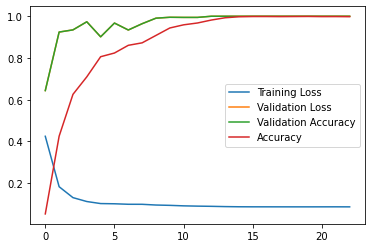

In [ ]:

model_predict = own_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

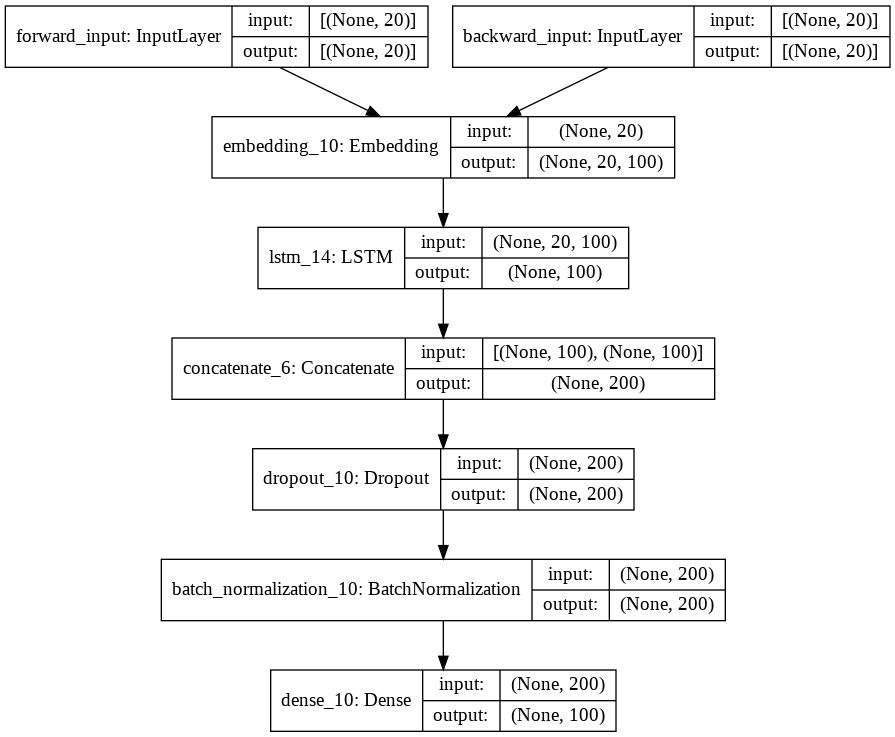

In [ ]:
from IPython.display import Image
Image('./Images/model_plot_bilstm.png')

## Part 4: Evaluation and Plotting Function

Following Code Block Description: 
Plotting function for the Embedding Matrix

In [ ]:
def plot_predicted(data, test_target_sense_data):
  tsne = TSNE(n_components=2, random_state=0)
  tsne_pred = tsne.fit_transform(data)

  x = tsne_pred[:,0]
  y = tsne_pred[:,1]
  sense = test_target_sense_data
  sense_embedding_space = pd.DataFrame(
      {'x': x,
      'y': y, 
      'sense': sense
      })

  #p = figure(title="Fashion")

  #source = ColumnDataSource(data=dict(x1=tsne_pred[:,0], x2=tsne_pred[:,1], names=tsne_pred))

  #p.scatter(x="x1", y="x2",size=8, source=source)
  #show(p)

  g = sns.lmplot(x = 'x', y = 'y', data=sense_embedding_space, hue='sense', palette=sns.color_palette("bright"), fit_reg=False)
  g._legend.remove()

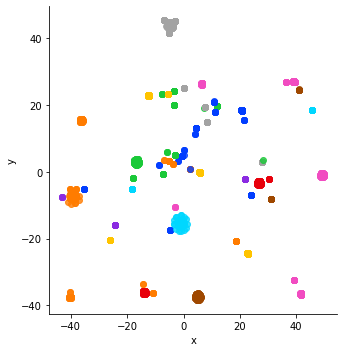

In [ ]:
plot_predicted(test_sense_embedding, test_target_word)

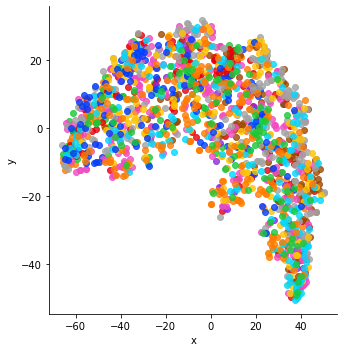

In [ ]:
plot_predicted(model_predict, test_target_word)

## Part 4.1
### Evaluation Code



**Parts 4.1, 4.2, 4.3 and 4.4 have the same code descriptions**

Following Code Block Description: 

1: We use TSNE to reduce the dimensionality of the embedding matrix. 

2: We transform the predicted embedding and test dataset embedding to a 2 dimensional vector. 

3: Then we find the cosine distance between the predicted and true output. 

4: With the help of the for loop we take the nearest distanced vector between the actual vectors and predicted one. The assigned predicted vector and the corresponding sense is stored in a list 


In [ ]:
tsne = TSNE(n_components=2, random_state=0)
tsne_pred = tsne.fit_transform(model_predict)
tsne_true = tsne.fit_transform(test_sense_embedding)
most_similar_sklearn = cosine_distances(tsne_pred, tsne_true)
cosined_prediction = []
cosined_pred_sense = []
for i in list(most_similar_sklearn):
  min_index = np.argmin(i)
  #print(min_index)
  cosined_prediction.append(tsne_true[min_index])
  cosined_pred_sense.append(test_target_sense_ids[min_index])
  #print(tsne_true[min_index])

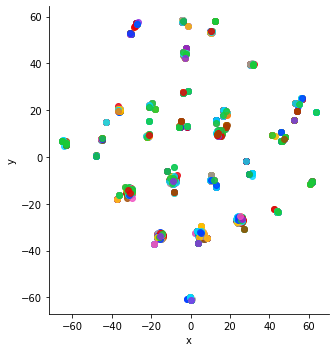

In [ ]:
plot_predicted(cosined_prediction, test_target_sense_ids)

Following Code Block Description: 

1) This following evaluation code difference based 2 things: The filter and no dimension reduction. 

2) First a list of dictionary with the actual embedding, the target sense and target word. 

3) In the first section of the for loop we filter the data based on the target word. This gives us all the embedding of sense of the particular word. 

4) We then calculate the cosine distance of predicted embedding and the embedding of the senses the target word and not all the words in the test set. 

5) We then store nearest distanced vector between the actual vectors and predicted one. The assigned predicted vector and the corresponding sense is stored in a list 

In [ ]:
test = []
for i in range(len(test_sense_embedding)):
  x = {"test_embedding": test_sense_embedding[i], "sense": test_target_sense_ids[i], "target_word": test_target_word[i]}
  test.append(x)

cosined_prediction_filter = []
cosined_pred_sense_filter = []
for i in range(len(test_sense_embedding)): 
  unique = []
  pred = []
  pred_sense = []
  tar_word = test[i]['target_word']
  a = list(filter(lambda word: word['target_word'] == tar_word, test))
  b = list({v['sense']:v for v in a}.values())
  for x in b: 
    unique.append(x['test_embedding'])
    pred_sense.append(x['sense'])
  final_true = np.asarray(unique)
  pred.append(model_predict[i])
  final_pred = np.asarray(pred)
  
  #print(final_true)
  #print(final_pred)
  #print(i)
  most_similar_trial = cosine_distances(final_pred, final_true)
  #print(most_similar_trial)
  for x in list(most_similar_trial):
    min_index = np.argmin(x)
    #print(min_index)
    #print(final_true[min_index])
    cosined_prediction_filter.append(final_true[min_index])
    cosined_pred_sense_filter.append(pred_sense[min_index])
    #print(final_true[min_index])



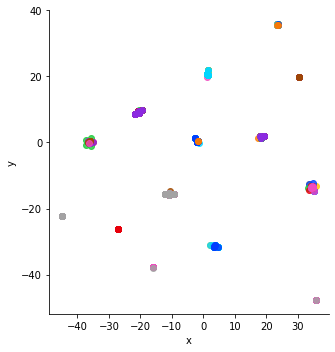

In [ ]:
plot_predicted(cosined_prediction_filter, test_target_sense_ids)

Following Code Block Description: 

The following loop is created to create the vector objects required for the calculation of the F-1 Score. 

We have 4 vectors: 

1) test_target: The target sense of the test dataset. 
2) cos_pred: The predicted sense based on cosine distance of all words
3) cos_pred_filter: The predicted sense based on cosine distance of target word
4) unique_target: As F-1 score required number representation, the sense words are converted to numbers and the above the 3 vectors have numeric representation. unique_targer has the corresponding sense of the numberic representation. 


In [ ]:
test_target= []
cos_pred = []
cos_pred_filter = []
unique_target = []
for i in range(len(test_target_sense_ids)):
  a = set(list(test_target_sense_ids))
  output = dict(zip(a, range(len(a))))
  unique_target = a
  test_target.append(output[test_target_sense_ids[i]])
  cos_pred.append(output[cosined_pred_sense[i]])
  cos_pred_filter.append(output[cosined_pred_sense_filter[i]])

##### F-1 Score 

In [ ]:

print(f1_score(test_target, cos_pred_filter, average='micro'))
print(classification_report(test_target, cos_pred_filter, target_names=unique_target, zero_division='warn'))

0.22914072229140722
                        precision    recall  f1-score   support

               3313901       0.00      0.00      0.00         7
organization%1:04:00::       0.00      0.00      0.00         1
       party%1:18:00::       0.00      0.00      0.00        17
       paper%1:10:00::       0.00      0.00      0.00        39
               2644302       0.17      1.00      0.29        10
               2893202       0.00      0.00      0.00        14
       paper%1:10:03::       0.00      0.00      0.00        41
               3165210       0.00      0.00      0.00        38
       paper%1:14:00::       0.00      0.00      0.00        20
               3165218       0.00      0.00      0.00         7
               2555504       0.00      0.00      0.00         8
               2439902       0.10      1.00      0.18         3
               3165213       0.00      0.00      0.00         8
               2439904       0.00      0.00      0.00        14
 performance%1:04:0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Part 3.2 Bidirectional LSTM + Attention

In [ ]:
def atten_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=50, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm = lstm_layer(embedded_forward)

    
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm = lstm_layer(embedded_backward)
    
    merged = concatenate([forward_lstm, backward_lstm],  name="bidirectional")     


    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)
    merged = SeqSelfAttention(attention_activation='sigmoid', name="attention_global")(merged)
    #merged = TimeDistributed(Dense(units=dense_unints, activation=act))(merged)
    
    merged = GlobalAveragePooling1D()(merged)
    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)
    preds = Dense(EMBEDDING_DIM, activation='relu')(merged)

    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds)


    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc',cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_bilstm_atten.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10, min_delta=0.001)
    #early_stopping =EarlyStopping(monitor='val_loss', mode='min', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/bilstm+att.png')
    return model_predict

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 20, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 20, 100)      80400       embedding_11[0][0]        

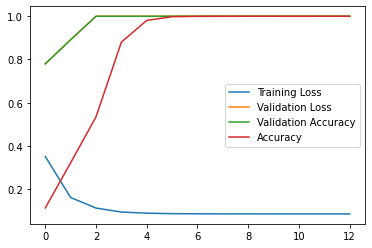

In [ ]:

model_predict_atten = atten_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

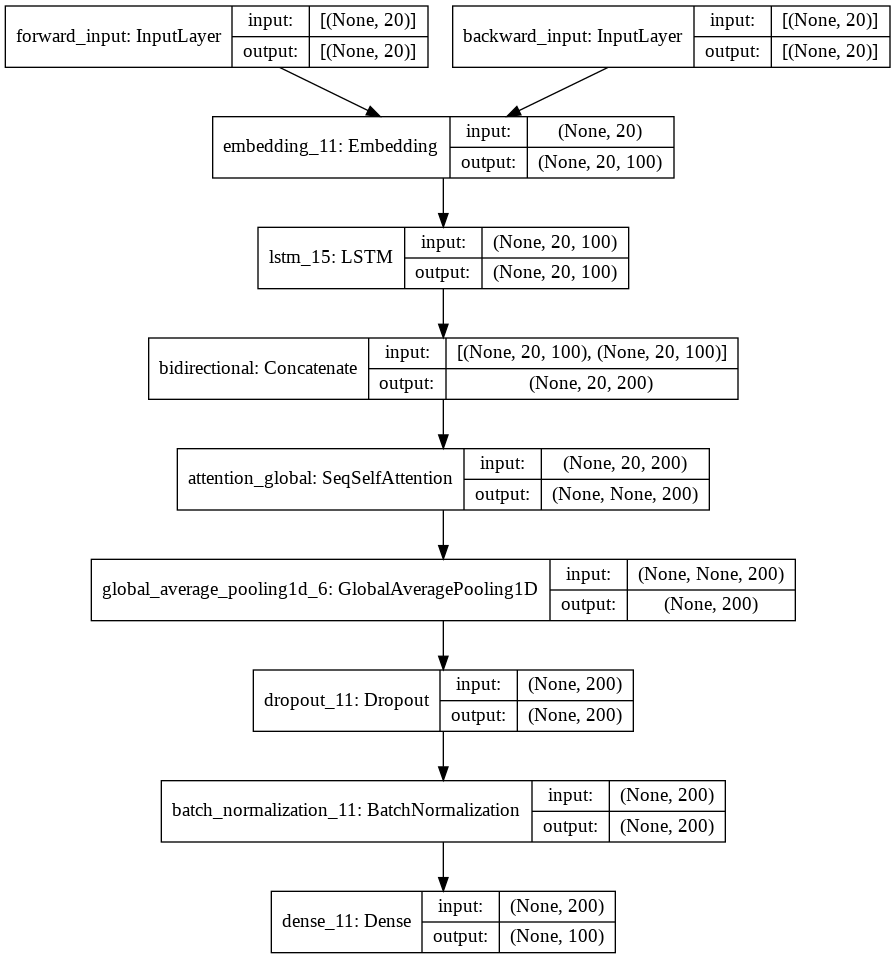

In [ ]:
from IPython.display import Image
Image('./Images/model_bilstm_atten.png')

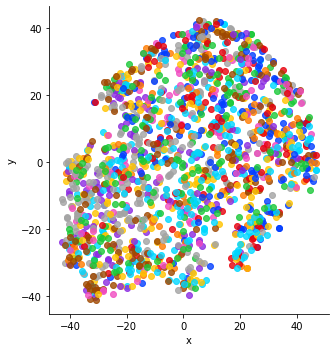

In [ ]:
plot_predicted(model_predict_atten, test_target_sense_ids)

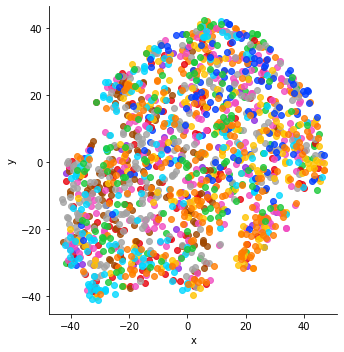

In [ ]:
plot_predicted(model_predict_atten, test_target_word)

## Part 4.2 

Evaluation Code


**Refer Code Description under Part 4.1**

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
tsne_pred = tsne.fit_transform(model_predict_atten)
tsne_true = tsne.fit_transform(test_sense_embedding)
most_similar_sklearn = cosine_distances(tsne_pred, tsne_true)
cosined_prediction = []
cosined_pred_sense = []
for i in list(most_similar_sklearn):
  min_index = np.argmin(i)
  #print(min_index)
  cosined_prediction.append(tsne_true[min_index])
  cosined_pred_sense.append(test_target_sense_ids[min_index])
  #print(tsne_true[min_index])

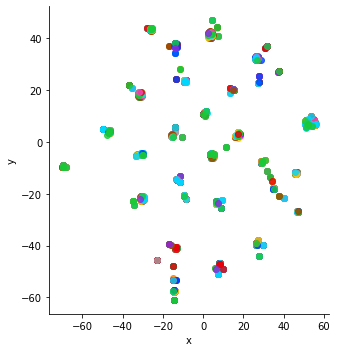

In [ ]:
plot_predicted(cosined_prediction, test_target_sense_ids)

In [ ]:
test = []
for i in range(len(test_sense_embedding)):
  x = {"test_embedding": test_sense_embedding[i], "sense": test_target_sense_ids[i], "target_word": test_target_word[i]}
  test.append(x)

cosined_prediction_filter = []
cosined_pred_sense_filter = []
for i in range(len(test_sense_embedding)): 
  unique = []
  pred = []
  pred_sense = []
  tar_word = test[i]['target_word']
  a = list(filter(lambda word: word['target_word'] == tar_word, test))
  b = list({v['sense']:v for v in a}.values())
  for x in b: 
    unique.append(x['test_embedding'])
    pred_sense.append(x['sense'])
  final_true = np.asarray(unique)
  pred.append(model_predict_atten[i])
  final_pred = np.asarray(pred)
  
  #print(final_true)
  #print(final_pred)
  #print(i)
  most_similar_trial = cosine_distances(final_pred, final_true)
  #print(most_similar_trial)
  for x in list(most_similar_trial):
    min_index = np.argmin(x)
    #print(min_index)
    #print(final_true[min_index])
    cosined_prediction_filter.append(final_true[min_index])
    cosined_pred_sense_filter.append(pred_sense[min_index])
    #print(final_true[min_index])



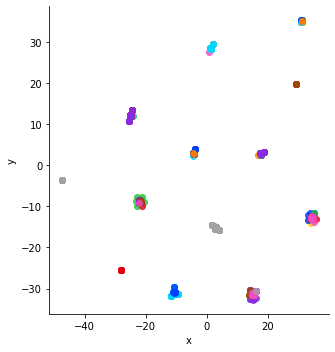

In [ ]:
plot_predicted(cosined_prediction_filter, test_target_sense_ids)

In [ ]:
test_target= []
cos_pred = []
cos_pred_filter = []
unique_target = []
for i in range(len(test_target_sense_ids)):
  a = set(list(test_target_sense_ids))
  output = dict(zip(a, range(len(a))))
  unique_target = a
  test_target.append(output[test_target_sense_ids[i]])
  cos_pred.append(output[cosined_pred_sense[i]])
  cos_pred_filter.append(output[cosined_pred_sense_filter[i]])

In [ ]:

print(f1_score(test_target, cos_pred_filter, average='micro'))
print(classification_report(test_target, cos_pred_filter, target_names=unique_target))

0.21170610211706103
                        precision    recall  f1-score   support

               3313901       0.00      0.00      0.00         7
organization%1:04:00::       0.00      0.00      0.00         1
       party%1:18:00::       0.00      0.00      0.00        17
       paper%1:10:00::       0.00      0.00      0.00        39
               2644302       0.17      1.00      0.29        10
               2893202       0.00      0.00      0.00        14
       paper%1:10:03::       0.00      0.00      0.00        41
               3165210       0.00      0.00      0.00        38
       paper%1:14:00::       0.00      0.00      0.00        20
               3165218       0.00      0.00      0.00         7
               2555504       0.00      0.00      0.00         8
               2439902       0.10      1.00      0.18         3
               3165213       0.00      0.00      0.00         8
               2439904       0.00      0.00      0.00        14
 performance%1:04:0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Part 3.3: BiLSTM with Attention layers at forward and backward input

In [ ]:
def at_lstm_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=50, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm = lstm_layer(embedded_forward)
    forward_lstm = SeqSelfAttention(attention_activation='sigmoid', name="attention_forward")(forward_lstm)
    
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm = lstm_layer(embedded_backward)
    backward_lstm = SeqSelfAttention(attention_activation='sigmoid', name="attention_backward")(backward_lstm)
    merged = concatenate([forward_lstm, backward_lstm])     

    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)
    #merged = TimeDistributed(Dense(units=dense_unints, activation=act))(merged)
    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)
    merged = GlobalAveragePooling1D()(merged)
    #merged = Dense(units=dense_unints, activation=act)(merged)
    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)    
    preds = Dense(EMBEDDING_DIM, activation='relu')(merged)

    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds)

 
    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc',cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_at_lstm.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10, min_delta=0.001)
    #early_stopping =EarlyStopping(monitor='val_loss', mode='min', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/atten_lstm.png')
    return model_predict


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 20, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 20, 100)      80400       embedding_12[0][0]        

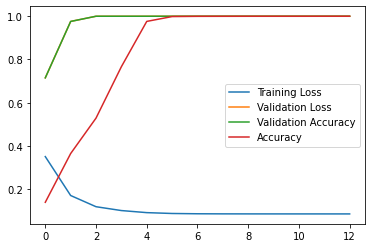

In [ ]:

model_at_lstm = at_lstm_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

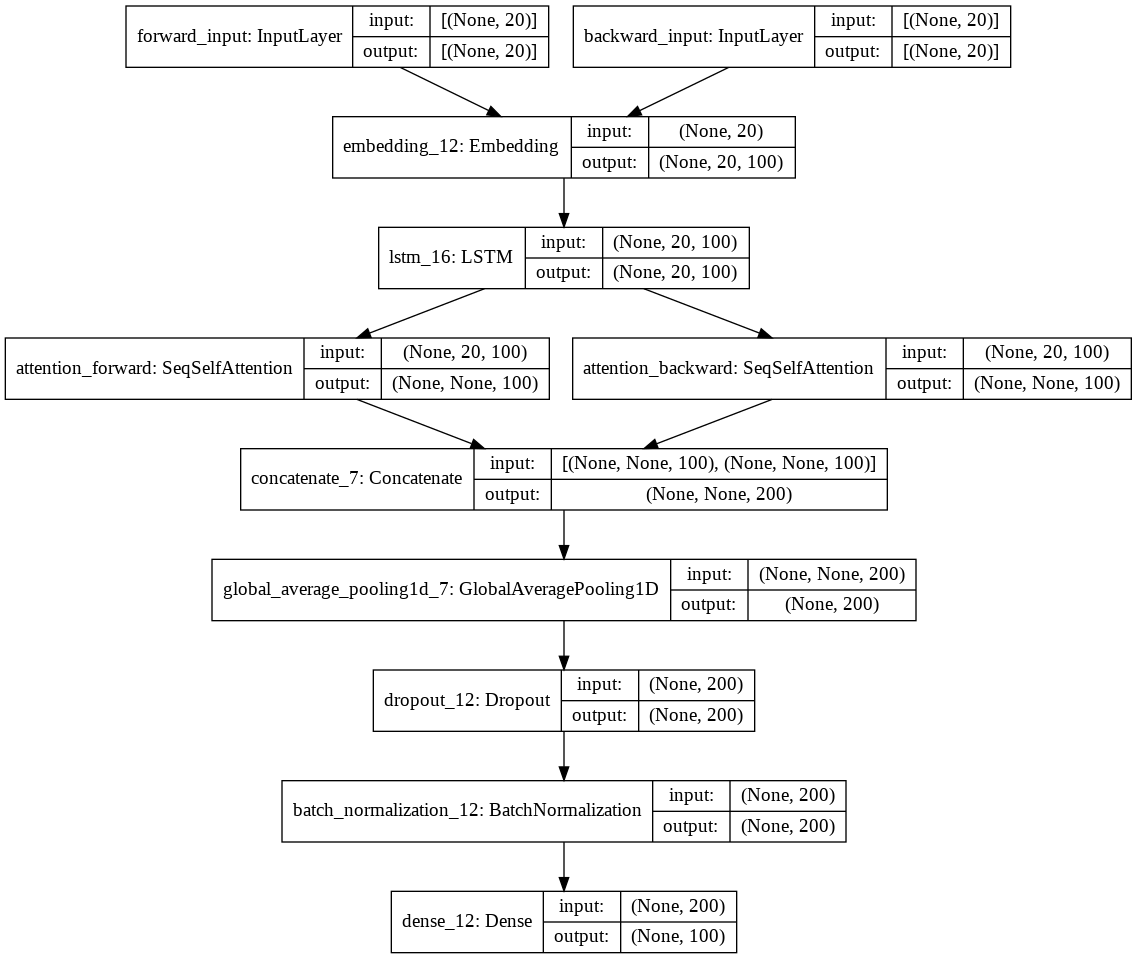

In [ ]:
from IPython.display import Image
Image('./Images/model_at_lstm.png')

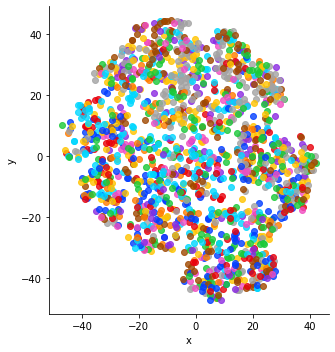

In [ ]:
plot_predicted(model_at_lstm, test_target_sense_ids)

## Part 4.3
Evalutation Code

**Refer Code Description under Part 4.1**

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
tsne_pred = tsne.fit_transform(model_at_lstm)
tsne_true = tsne.fit_transform(test_sense_embedding)
most_similar_sklearn = cosine_distances(tsne_pred, tsne_true)
cosined_prediction = []
cosined_pred_sense = []
for i in list(most_similar_sklearn):
  min_index = np.argmin(i)
  #print(min_index)
  cosined_prediction.append(tsne_true[min_index])
  cosined_pred_sense.append(test_target_sense_ids[min_index])
  #print(tsne_true[min_index])

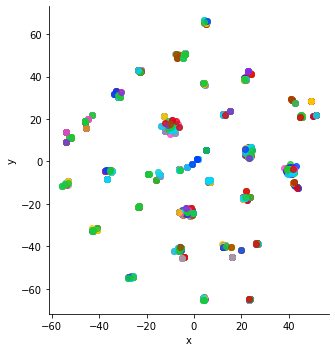

In [ ]:
plot_predicted(cosined_prediction, test_target_sense_ids)

In [ ]:
test = []
for i in range(len(test_sense_embedding)):
  x = {"test_embedding": test_sense_embedding[i], "sense": test_target_sense_ids[i], "target_word": test_target_word[i]}
  test.append(x)

cosined_prediction_filter = []
cosined_pred_sense_filter = []
for i in range(len(test_sense_embedding)): 
  unique = []
  pred = []
  pred_sense = []
  tar_word = test[i]['target_word']
  a = list(filter(lambda word: word['target_word'] == tar_word, test))
  b = list({v['sense']:v for v in a}.values())
  for x in b: 
    unique.append(x['test_embedding'])
    pred_sense.append(x['sense'])
  final_true = np.asarray(unique)
  pred.append(model_at_lstm[i])
  final_pred = np.asarray(pred)
  
  #print(final_true)
  #print(final_pred)
  #print(i)
  most_similar_trial = cosine_distances(final_pred, final_true)
  #print(most_similar_trial)
  for x in list(most_similar_trial):
    min_index = np.argmin(x)
    #print(min_index)
    #print(final_true[min_index])
    cosined_prediction_filter.append(final_true[min_index])
    cosined_pred_sense_filter.append(pred_sense[min_index])
    #print(final_true[min_index])



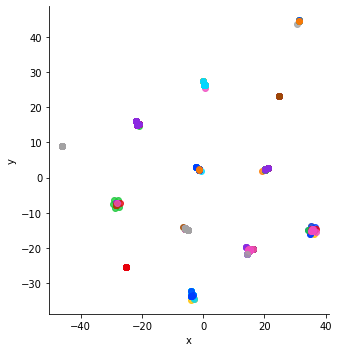

In [ ]:
plot_predicted(cosined_prediction_filter, test_target_sense_ids)

In [ ]:
test_target= []
cos_pred = []
cos_pred_filter = []
unique_target = []
for i in range(len(test_target_sense_ids)):
  a = set(list(test_target_sense_ids))
  output = dict(zip(a, range(len(a))))
  unique_target = a
  test_target.append(output[test_target_sense_ids[i]])
  cos_pred.append(output[cosined_pred_sense[i]])
  cos_pred_filter.append(output[cosined_pred_sense_filter[i]])

In [ ]:

print(f1_score(test_target, cos_pred_filter, average='micro'))
print(classification_report(test_target, cos_pred_filter, target_names=unique_target))

0.21170610211706103
                        precision    recall  f1-score   support

               3313901       0.00      0.00      0.00         7
organization%1:04:00::       0.00      0.00      0.00         1
       party%1:18:00::       0.00      0.00      0.00        17
       paper%1:10:00::       0.00      0.00      0.00        39
               2644302       0.17      1.00      0.29        10
               2893202       0.00      0.00      0.00        14
       paper%1:10:03::       0.00      0.00      0.00        41
               3165210       0.00      0.00      0.00        38
       paper%1:14:00::       0.00      0.00      0.00        20
               3165218       0.00      0.00      0.00         7
               2555504       0.00      0.00      0.00         8
               2439902       0.10      1.00      0.18         3
               3165213       0.00      0.00      0.00         8
               2439904       0.00      0.00      0.00        14
 performance%1:04:0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Part 3.4: Multiple Layer Model

In [ ]:
def stacked_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data=None, val_backward_data=None, val_sense_embedding=None,
              n_units=100, dense_unints=256, is_training=True, EMBEDDING_DIM=100, epochs=50, batch_size=512, init_word_vecs=None):
    
    embedding_layer = Embedding(len(word_to_id),
                                EMBEDDING_DIM,
                                weights=[init_word_vecs],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(n_units, dropout=0.2, recurrent_dropout=0.2, return_sequences = True, return_state = True)
    lstm_layer_forward = LSTM(units=200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state = True)
    lstm_layer_backward = LSTM(units=200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state = True, go_backwards=True)
    forward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='forward_input')
    embedded_forward = embedding_layer(forward_input)
    forward_lstm, forward_h, forward_c = lstm_layer(embedded_forward)

    
    backward_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='backward_input')
    embedded_backward = embedding_layer(backward_input)
    backward_lstm, backward_h, backward_c = lstm_layer(embedded_backward)
    
    merged_outputs = concatenate([forward_lstm, backward_lstm], name='bidirectional_1')
    state_h = concatenate([forward_h, backward_h], name='hidden_state')
    state_c = concatenate([forward_c, backward_c], name='cell_state')
    #encoder_state = [state_h, state_c]

    encoder_attention = SeqSelfAttention(attention_activation='sigmoid', name='attention_layer')(merged_outputs)
    
    decoder_forward, _, _ = lstm_layer_forward(encoder_attention, initial_state= [state_h, state_c])
    decoder_backward, _, _ = lstm_layer_backward(encoder_attention, initial_state= [state_h, state_c])
    decoder_bi = concatenate([decoder_forward, decoder_backward], name='bidirectional_2')
    #merged = TimeDistributed(Dense(units=dense_unints, activation=act))(decoder_bi)
    #merged = Dropout(0.2)(merged) if is_training else merged
    #merged = BatchNormalization()(merged)
    merged = GlobalAveragePooling1D()(decoder_bi)
    #merged = Dense(units=dense_unints, activation=act)(merged)
    merged = Dropout(0.2)(merged) if is_training else merged
    merged = BatchNormalization()(merged)    
    preds = Dense(EMBEDDING_DIM, activation='relu')(merged)

    
    ## train the model 
    model = Model(inputs=[forward_input, backward_input], outputs=preds)

    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc',cos_distance, f1_m])
    
    model.summary()
    plot_model(model, to_file='./Images/model_plot_seq.png', show_shapes=True, show_layer_names=True)
    early_stopping =EarlyStopping(monitor='val_acc', mode='max', patience=10, min_delta=0.001)
    #early_stopping =EarlyStopping(monitor='val_loss', mode='min', patience=10)
    #bst_model_path = STAMP + '.h5'
    bst_model_path = "weights.best.hdf5"
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
      
    hist = model.fit([train_forward_data, train_backward_data], train_sense_embedding, 
                     validation_data=([val_forward_data, val_backward_data], val_sense_embedding), 
                     epochs=epochs, batch_size=batch_size, shuffle=True, 
                     callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(bst_model_path)
    model.evaluate([test_forward_data, test_backward_data], test_sense_embedding)
    model_predict = model.predict([test_forward_data, test_backward_data])
    bst_val_score = min(hist.history['val_acc'])
    print(hist.history.keys())
    print('min val acc is: %f' % (bst_val_score))
    fig = plt.figure()
    plt.plot(hist.history["loss"], label="Training Loss")
    plt.plot(hist.history["val_acc"], label="Validation Loss")
    plt.plot(hist.history["val_acc"], label="Validation Accuracy")
    plt.plot(hist.history["acc"], label="Accuracy")
    plt.legend()
    plt.show()
    fig.savefig('./Images/seq2seq.png')
    return model_predict

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
backward_input (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 20, 100)      6429900     forward_input[0][0]              
                                                                 backward_input[0][0]             
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, 20, 100), (N 80400       embedding_13[0][0]        

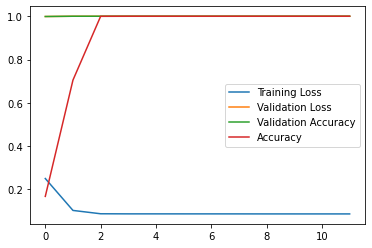

In [ ]:

model_predict_seq = stacked_model(train_forward_data, train_backward_data, train_sense_embedding, 
              val_forward_data, val_backward_data, val_sense_embedding, 
              init_word_vecs=init_emb)

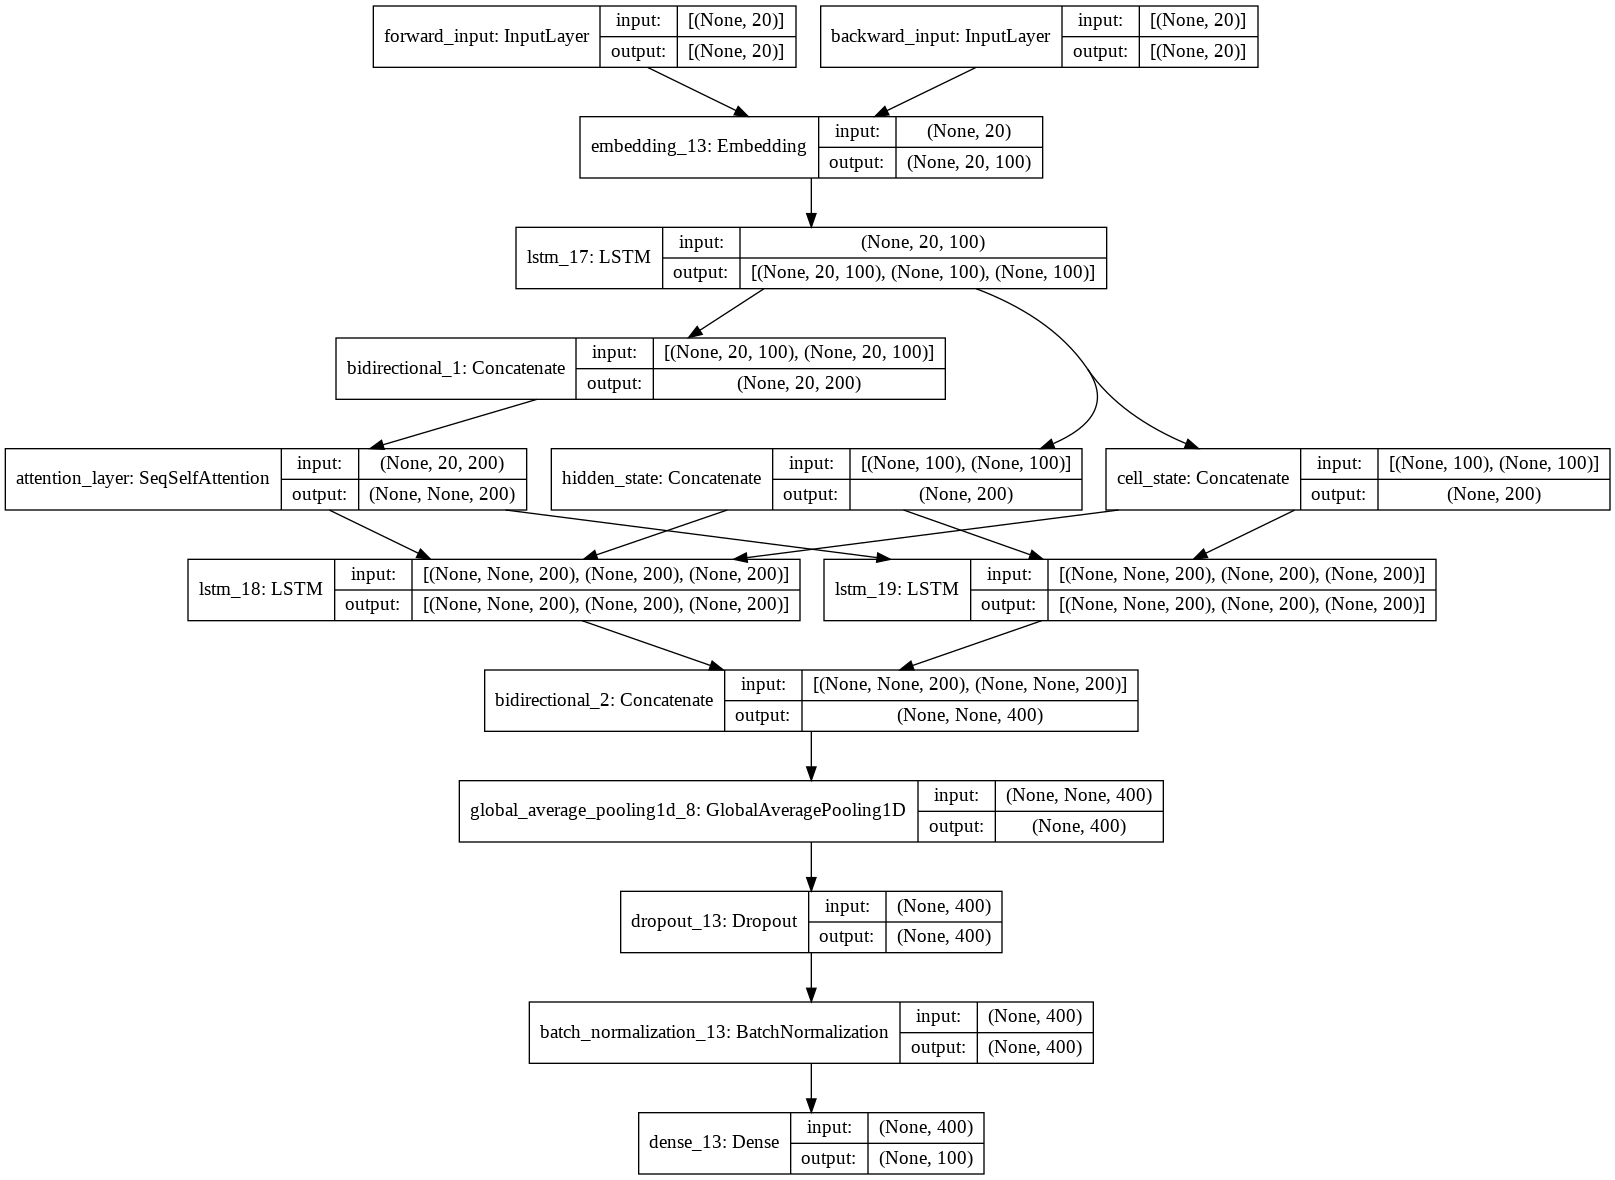

In [ ]:
from IPython.display import Image
Image('./Images/model_plot_seq.png')

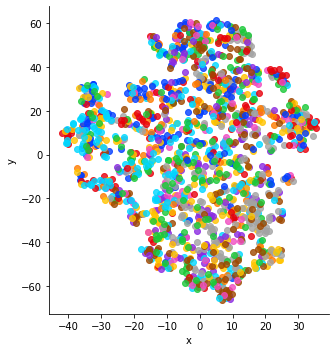

In [ ]:
plot_predicted(model_predict_seq, test_target_sense_ids)

## Part 4.4
Evaluation Code

**Refer Code Description under Part 4.1**

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
tsne_pred = tsne.fit_transform(model_predict_seq)
tsne_true = tsne.fit_transform(test_sense_embedding)
most_similar_sklearn = cosine_distances(tsne_pred, tsne_true)
cosined_prediction = []
cosined_pred_sense = []
for i in list(most_similar_sklearn):
  min_index = np.argmin(i)
  #print(min_index)
  cosined_prediction.append(tsne_true[min_index])
  cosined_pred_sense.append(test_target_sense_ids[min_index])
  #print(tsne_true[min_index])

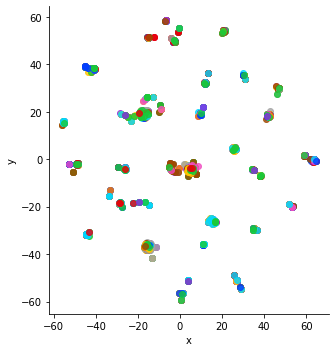

In [ ]:
plot_predicted(cosined_prediction, test_target_sense_ids)

In [ ]:
test = []
for i in range(len(test_sense_embedding)):
  x = {"test_embedding": test_sense_embedding[i], "sense": test_target_sense_ids[i], "target_word": test_target_word[i]}
  test.append(x)

cosined_prediction_filter = []
cosined_pred_sense_filter = []
for i in range(len(test_sense_embedding)): 
  unique = []
  pred = []
  pred_sense = []
  tar_word = test[i]['target_word']
  a = list(filter(lambda word: word['target_word'] == tar_word, test))
  b = list({v['sense']:v for v in a}.values())
  for x in b: 
    unique.append(x['test_embedding'])
    pred_sense.append(x['sense'])
  final_true = np.asarray(unique)
  pred.append(model_predict_seq[i])
  final_pred = np.asarray(pred)
  
  #print(final_true)
  #print(final_pred)
  #print(i)
  most_similar_trial = cosine_distances(final_pred, final_true)
  #print(most_similar_trial)
  for x in list(most_similar_trial):
    min_index = np.argmin(x)
    #print(min_index)
    #print(final_true[min_index])
    cosined_prediction_filter.append(final_true[min_index])
    cosined_pred_sense_filter.append(pred_sense[min_index])
    #print(final_true[min_index])



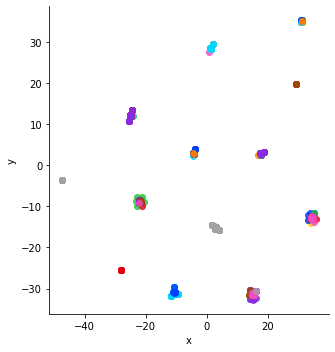

In [ ]:
plot_predicted(cosined_prediction_filter, test_target_sense_ids)

In [ ]:
test_target= []
cos_pred = []
cos_pred_filter = []
unique_target = []
for i in range(len(test_target_sense_ids)):
  a = set(list(test_target_sense_ids))
  output = dict(zip(a, range(len(a))))
  unique_target = a
  test_target.append(output[test_target_sense_ids[i]])
  cos_pred.append(output[cosined_pred_sense[i]])
  cos_pred_filter.append(output[cosined_pred_sense_filter[i]])

In [ ]:

print(f1_score(test_target, cos_pred_filter, average='micro'))
print(classification_report(test_target, cos_pred_filter, target_names=unique_target))

0.21170610211706103
                        precision    recall  f1-score   support

               3313901       0.00      0.00      0.00         7
organization%1:04:00::       0.00      0.00      0.00         1
       party%1:18:00::       0.00      0.00      0.00        17
       paper%1:10:00::       0.00      0.00      0.00        39
               2644302       0.17      1.00      0.29        10
               2893202       0.00      0.00      0.00        14
       paper%1:10:03::       0.00      0.00      0.00        41
               3165210       0.00      0.00      0.00        38
       paper%1:14:00::       0.00      0.00      0.00        20
               3165218       0.00      0.00      0.00         7
               2555504       0.00      0.00      0.00         8
               2439902       0.10      1.00      0.18         3
               3165213       0.00      0.00      0.00         8
               2439904       0.00      0.00      0.00        14
 performance%1:04:0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
